In [1]:
import os
import sys
py_files_dir = os.path.abspath("../../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import itertools
import helper_functions as funcs
import instrument_matrices as matrices
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy_minimize_m3 as m3

# Setting Up Initial Instrument Parameters

In [2]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

theta_pol = -3.7768300814382085
delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.45649443676091783  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32208684844990476  # Add your actual delta_derot value
offset_derot = 1  # Add your actual offset_derot value
delta_opts = -0.14961975453168286 # Add your actual delta_opts value
epsilon_opts = 0.01868703913240439  # Add your actual epsilon_opts value
rot_opts = -2.3950912229452315  # Add your actual rot_opts value
delta_FLC = 0.3287256097107294  # Add your actual delta_FLC value
rot_FLC = 1.5231767001488516  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
# double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Load .csv files

In [3]:
csv_directory = '../../../data/unpolarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

# Plotting the Data in the HWP angle frame

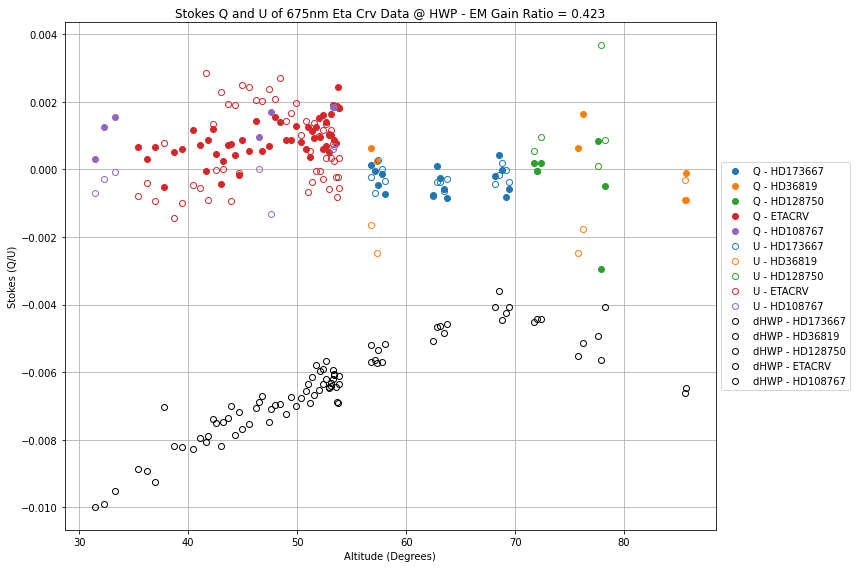

In [4]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
dHWP_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

inst_matrices_at_HWP_with_M3 = []
first_rows_with_M3 = []

measurement_matrices_with_M3 = []
measurement_matrices = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        pa = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # NO M3
            # Calculate instrument matrix at HWP
            delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
            epsilon_m3 = 0.016  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
            offset_m3 = -5  # NOTE: Made this zero too for testing purposes
            fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
                delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
                rot_FLC, em_gain]
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, pa, altitude, HWP_ang, IMR_ang)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            # double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take all rows and normalize by the double sum I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : ] / double_sum_matrix_at_HWP[0, 0])  

            # WITH M3 
            # Calculate instrument matrix at HWP
            # delta_m3 = 0 # (waves) - assumed to be a perfect mirror for now
            # epsilon_m3 = 0.0125  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
            # offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
            # these_inst_matrices_at_HWP_with_M3 = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, 0, altitude, HWP_ang, IMR_ang)
            # double_diff_matrix_at_HWP_with_M3 = these_inst_matrices_at_HWP_with_M3[0]
            # double_sum_matrix_at_HWP_with_M3 = these_inst_matrices_at_HWP_with_M3[1]

            # # Setting the I component to be 1
            # # double_diff_matrix_at_HWP[0, 0] = 1

            # # Saving instrument matrices
            # inst_matrices_at_HWP_with_M3.append(double_diff_matrix_at_HWP_with_M3)
            # inst_matrices_at_HWP_with_M3.append(double_sum_matrix_at_HWP_with_M3)

            # # Take only the first row and I, Q, U, components (no V)
            # first_rows_with_M3.append(double_diff_matrix_at_HWP_with_M3[0, : ])

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurement_matrices.append(measurement_matrix)
#           measurements = np.array(this_cycle_intensities).reshape(-1, 1)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape total counts to a column vector
            
#            if obj == "HD36819":
#                print("Altitude: " + str(altitude))
#                print(np.array(this_cycle_intensities).reshape(-1, 1))
            
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # print("Altitude: " + str(altitude))
            # print("Measurement Matrix (No M3): " + str(measurement_matrix))

            ## NO M3
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            # measurement_matrix_with_M3 = np.vstack(first_rows_with_M3)
            # measurements_with_M3 = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            # # errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # measurement_matrices_with_M3.append(measurement_matrix_with_M3)

            # print("Altitude: " + str(altitude))
            # print("Measurement Matrix (With M3): " + str(measurement_matrix_with_M3))

            # ACTUAL INVERSION
            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            measurement_matrix[:, 0] = 1
#            s_HWP = np.linalg.pinv(measurement_matrix[:, 1 :]) @ measurements
            s_HWP = np.linalg.pinv(measurement_matrix[:,:-1]) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            dHWP = s_HWP[0]
            Q = s_HWP[1]
            U = s_HWP[2]
#            Q = s_HWP[1]
#            U = s_HWP[2]

            Q_err = s_HWP_err[0]
            U_err = s_HWP_err[1]

            # Append Q, U, altitude, and errors to the lists
            dHWP_list.append((altitude, dHWP, "k", obj))  
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            first_rows_with_M3 = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, 
                 # yerr=Q_err, 
                 label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, 
                 # yerr=U_err, 
                 label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

for (altitude, dHWP, color, obj) in dHWP_list:
    label = f'dHWP - {obj}' if f'dHWP - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, dHWP, label=label, linestyle='None', marker='o', color="k", markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'dHWP - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
print(measurement_matrix)
print(double_diff_matrix_at_HWP)
print(double_sum_matrix_at_HWP)

[[ 1.         -0.04393071 -0.77242312  0.34613622]
 [ 1.          0.12431818  0.83220539  0.10498404]
 [ 1.          0.82516654 -0.06064838  0.18956667]
 [ 1.         -0.82291315  0.14297939  0.14354605]]
[[ 1.81684213e-03 -1.16948770e+00  2.03195967e-01  2.04001291e-01]
 [-7.36695650e-04  4.74205484e-01 -8.23921805e-02 -8.27187246e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[ 1.42115568  0.06296424  0.09670729  0.27728934]
 [-0.57320079 -0.15991726 -0.21883918 -0.70389478]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [6]:
# With M3 diattenuation
print("With M3 diattenuation")
inverse_s_in_list = []

for i in range(0, 10000):
    s_in = np.array([1, 0.01, 0.01, 0]).reshape(-1, 1)

    # print(s_in)

    matrix_with_M3 = measurement_matrices_with_M3[0]

    # print("Matrix with M3: " + str(matrix_with_M3))

    forward_s_out = matrix_with_M3 @ s_in + np.random.normal(0, 0.01, (4, 1))
    # print("M.S_in: " + str(forward_s_out))

    inverse_s_in = np.linalg.pinv(matrix_with_M3[:, 1 : ]) @ (forward_s_out - matrix_with_M3[:, 0].reshape(-1, 1))
    inverse_s_in_list.append(inverse_s_in)

    # print("Inversion of the previous operation: " + str(inverse_s_in))

print("Mean of the inversion: " + str(np.mean(inverse_s_in_list, axis = 0)))

print("With M3 diattenuation - All Columns")
inverse_s_in_list = []

for i in range(0, 10000):
    s_in = np.array([1, 0.01, 0.01, 0]).reshape(-1, 1)

    # print(s_in)

    matrix_with_M3 = measurement_matrices_with_M3[0]

    # print("Matrix with M3: " + str(matrix_with_M3))

    forward_s_out = matrix_with_M3 @ s_in + np.random.normal(0, 0.01, (4, 1))
    # print("M.S_in: " + str(forward_s_out))

    inverse_s_in = np.linalg.pinv(matrix_with_M3) @ (forward_s_out - matrix_with_M3[:, 0].reshape(-1, 1))
    inverse_s_in_list.append(inverse_s_in)

    # print("Inversion of the previous operation: " + str(inverse_s_in))

print("Mean of the inversion (All Columns): " + str(np.mean(inverse_s_in_list, axis = 0)))

# NO M3 diattenuation
# print("NO M3 diattenuation")

# s_in = np.array([1, 0.01, 0, 0]).reshape(-1, 1)

# matrix_no_M3 = measurement_matrices[0]

# print("Matrix with M3: " + str(matrix_no_M3))

# # forward_s_out = matrix_no_M3 @ s_in
# # print("M.S_in: " + str(forward_s_out))

# inverse_s_in = np.linalg.pinv(matrix_no_M3) @ forward_s_out

# print("Inversion of the previous operation: " + str(inverse_s_in))

With M3 diattenuation


IndexError: list index out of range

# Plotting in the On-Sky Frame

In [ ]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            # Calculate instrument matrix for equatorial reference frame
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


Parallactic Angle: -84.9084509958819 Altitude: 56.56625 HWP Angle: 0.0 IMR Angle: 92.72502


NameError: name 'double_diff_factor' is not defined

# Plotting Forward Model

Best Fit M3 Diattenuation: 0.009057923239793323
Best Fit Offset: -4.538251380067541


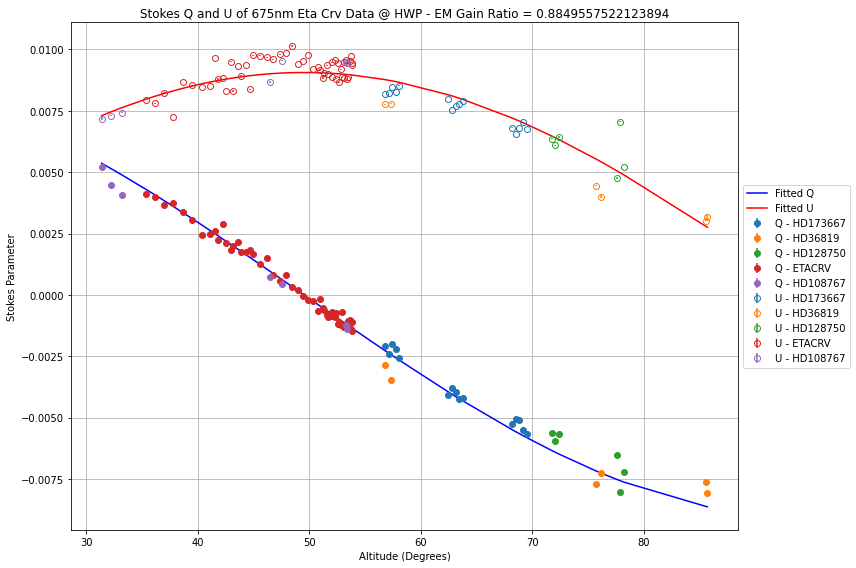

In [ ]:
# Extract altitudes, Q_data, and U_data from the previous block of code
altitudes = [item[0] for item in Q_list]  # Extracting altitudes from Q_list (they are the same for U_list)
Q_data = np.array([item[1] for item in Q_list]).flatten()
U_data = np.array([item[1] for item in U_list]).flatten()

# Initial guesses for delta_m3, epsilon_m3, and offset
initial_guesses = [0, 0.01, 1]
bounds = [(0, 1), (-0.5, 0.5), (-10, 10)]

# Perform the minimization using Nelder-Mead with bounds
result = minimize(m3.residuals, initial_guesses, args=(altitudes, Q_data, U_data), method='Nelder-Mead', bounds=bounds)

# Extract the best-fit parameters
delta_m3_best, epsilon_m3_best, offset_best = result.x

print("Best Fit M3 Diattenuation: " + str(epsilon_m3_best))
print("Best Fit Offset: " + str(offset_best))

# Calculate the fitted Q and U values
Q_fitted, U_fitted = m3.propagate_unpol_source(delta_m3_best, epsilon_m3_best, offset_best, altitudes)
#Q_fitted, U_fitted = m3.propagate_unpol_source(0, 0.0176, -2.5, altitudes)

# Sort the fitted values by altitude
sorted_indices = np.argsort(altitudes)
altitudes_sorted = np.array(altitudes)[sorted_indices]
Q_fitted_sorted = Q_fitted[sorted_indices]
U_fitted_sorted = U_fitted[sorted_indices]

# Plotting the data and the fitted line
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

# Plot the fitted line with different colors for Q and U
plt.plot(altitudes_sorted, Q_fitted_sorted, label='Fitted Q', linestyle='-', color='blue')
plt.plot(altitudes_sorted, U_fitted_sorted, label='Fitted U', linestyle='-', color='red')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes Parameter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Matrix Inversion for On-Sky Frame of Reference

In [ ]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0.5 # (waves) - assumed to be zero for now
epsilon_m3 = 0.01244  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

Fixed Params:  [0.5, 0.01244, -2.5, 0.451, -2.642, 0.32, -0.011, -0.163, 0.036, -7.151, 0.302, 0.256, 0.423]
FL1: [[ 0.21743376  0.14133793 -0.1560172   0.05440276]
 [ 0.21743376  0.14133793 -0.1560172   0.05440276]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR1: [[ 0.48565048 -0.31667232  0.34755257 -0.12158225]
 [-0.48565048  0.31667232 -0.34755257  0.12158225]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FL2: [[ 0.20949358 -0.04853569  0.10156619  0.17668095]
 [ 0.20949358 -0.04853569  0.10156619  0.17668095]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR2: [[ 0.50442158  0.13220149 -0.26139161 -0.41065597]
 [-0.50442158 -0.13220149  0.26139161  0.41065597]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Fixed Params:  [0.5, 0.01244, -2.5, 0.451, -2.642, 

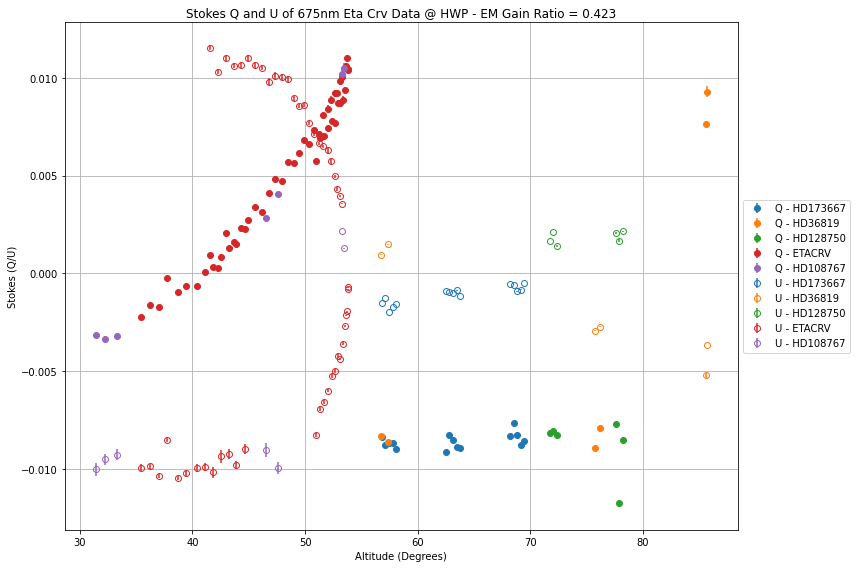

In [ ]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            # Calculate instrument matrix at HWP
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            # double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
